In [1]:
import pandas as pd
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
FOLDER = '../../../data_handson/kuzushiji/'
IMAGES = FOLDER + 'train_images/'
print(os.listdir(FOLDER))

['.DS_Store', 'unicode_translation.csv', 'image', 'train.csv', 'train_images', 'sample_submission.csv']


In [4]:
df_train = pd.read_csv(FOLDER + 'train.csv')
df_sub = pd.read_csv(FOLDER + 'sample_submission.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(FOLDER + 'unicode_translation.csv').values}

In [5]:
df_sub_idx = df_sub.set_index("image_id")
df_train_idx = df_train.set_index("image_id")
idx_train = df_train['image_id']

In [6]:
def label_reader(label):
    try:
        code_arr = np.array(label['labels'].split(' ')).reshape(-1, 5)
    except:
        return
    return code_arr

def cvtToPos(feat_map): # feat_map = [cx, cy, w, h] -> [x0, y0, x1, y1]
    left_upper_x = feat_map[0] - int(feat_map[2]/2)
    left_upper_y = feat_map[1] - int(feat_map[3]/2)
    right_lower_x = feat_map[0] + int(feat_map[2]/2)
    right_lower_y = feat_map[1] + int(feat_map[3]/2)
    return np.array([left_upper_x, left_upper_y, right_lower_x, right_lower_y])

In [7]:
i= 101
j = 10

fname = idx_train[i]
image_path = IMAGES + fname + '.jpg'
code = label_reader(df_train_idx.loc[idx_train[i]])[j]
charactor = unicode_map[code[0]]

In [8]:
df_code = pd.DataFrame()
for idx in tqdm(idx_train[:100]):
    df_code_temp = pd.DataFrame(label_reader(df_train_idx.loc[idx]))
    df_code_temp['image_id'] = idx
    df_code = pd.concat([df_code, df_code_temp], axis=0, sort=False)

100%|██████████| 100/100 [00:00<00:00, 386.80it/s]


In [9]:
df_code.head()

,0,1,2,3,4,image_id
0,U+306F,1231,3465,133,53,100241706_00004_2
1,U+304C,275,1652,84,69,100241706_00004_2
2,U+3044,1495,1218,143,69,100241706_00004_2
3,U+3051,220,3331,53,91,100241706_00004_2
4,U+306B,911,1452,61,92,100241706_00004_2


In [10]:
df_code.columns = ['char', 'x', 'y', 'w', 'h', 'image_id']
df_code[['x', 'y', 'w', 'h']] = df_code[['x', 'y', 'w', 'h']].astype('int32') 

In [11]:
from sklearn.cluster import KMeans

In [12]:
def find_n(coord_center, min_n=3, max_n=10):
    stds_list = []
    for n in range(min_n, max_n):
        km = KMeans(n_clusters=n)
        X = coord_center.copy()
        X[:, 1] = X[:, 1]/100
        km_cluster = km.fit(X)

        df_center = pd.DataFrame(coord_center)
        df_center['col_n'] = km_cluster.labels_

        cols = df_center['col_n'].unique()
        for col in cols:
            temp = df_center.query('col_n == {}'.format(col))
        stds_list.append(df_center.groupby('col_n').std().mean().values)

    stds = np.array(stds_list)
    xsm = np.log(stds[:,0])
    n_xsm = np.argmin(xsm[1:] - xsm[:-1]) + 1
    
    return n_xsm+min_n

In [13]:
def draw_kmean(coord_center, n):
    km = KMeans(n_clusters=n)
    X = coord_center.copy()
    X[:, 1] = X[:, 1]/100
    km_cluster = km.fit(X)

    df_center = pd.DataFrame(coord_center)
    df_center['col_n'] = km_cluster.labels_

    cols = df_center['col_n'].unique()
    for col in cols:
        temp = df_center.query('col_n == {}'.format(col))
        plt.scatter(temp[0], temp[1])
    plt.show() 

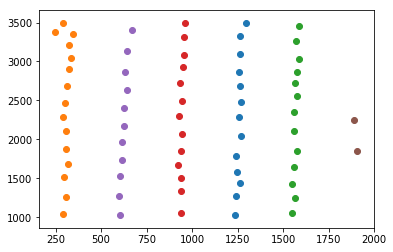

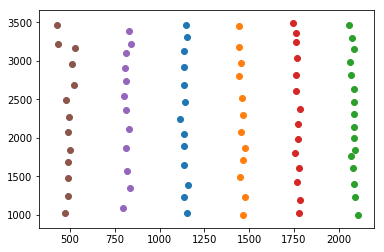

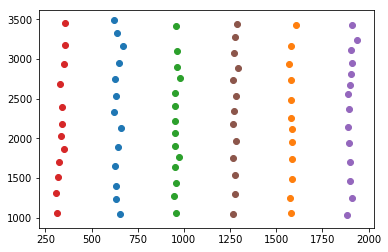

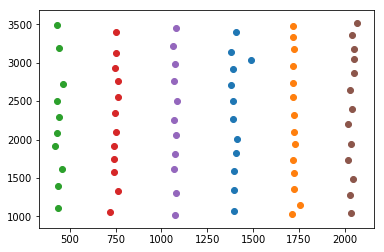

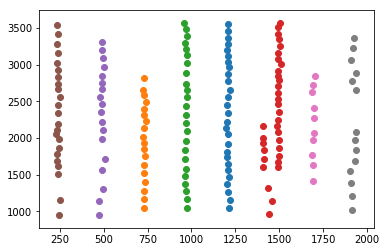

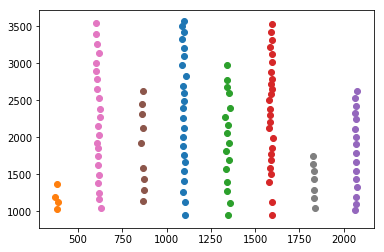

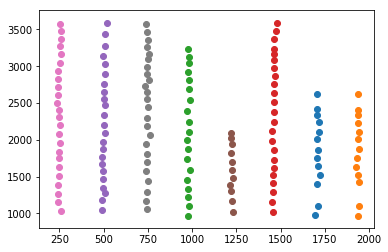

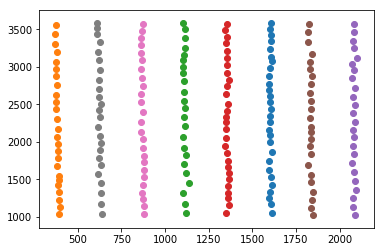

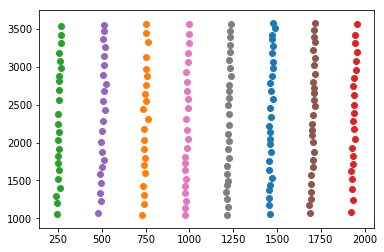

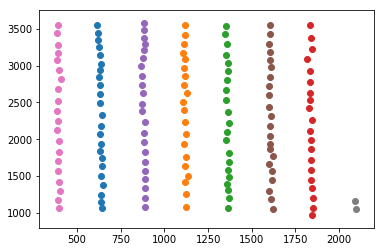

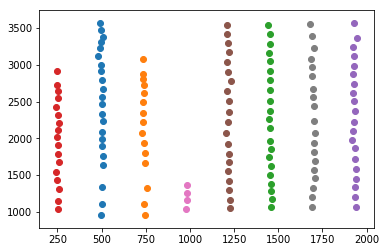

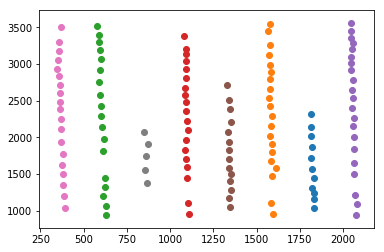

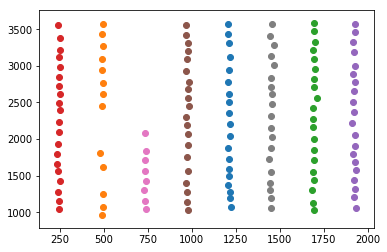

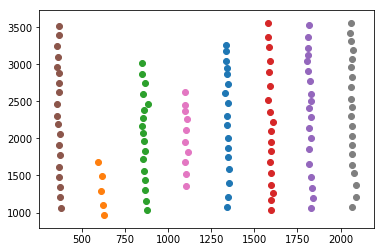

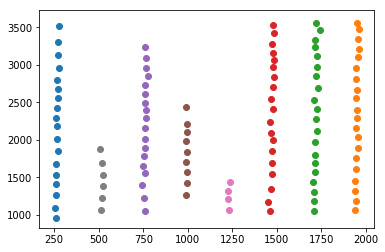

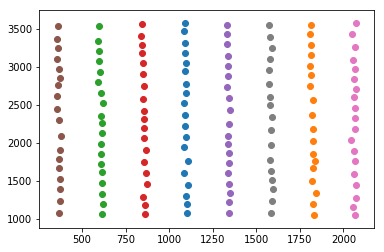

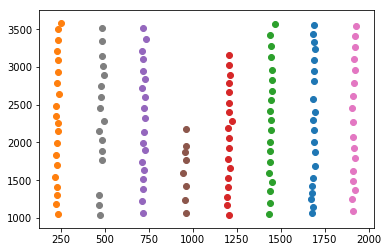

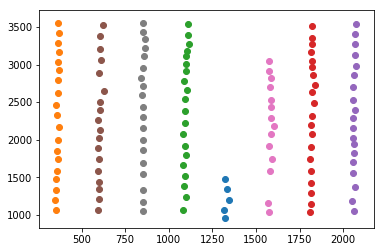

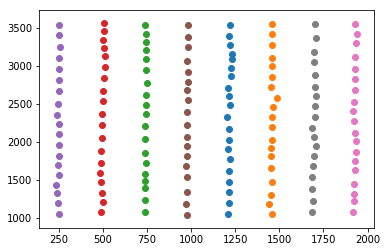

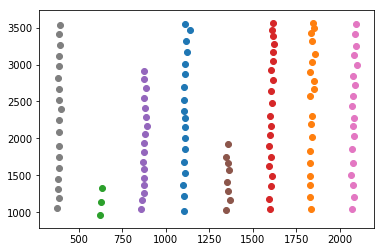

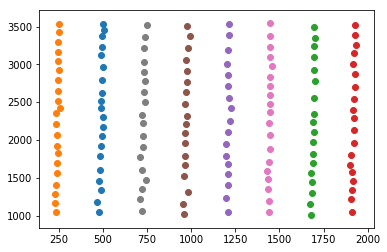

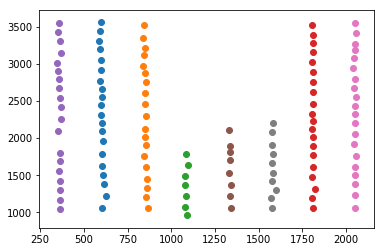

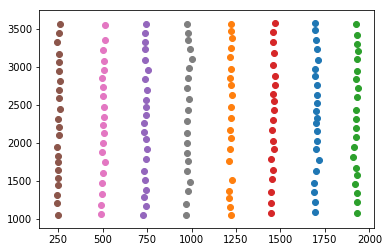

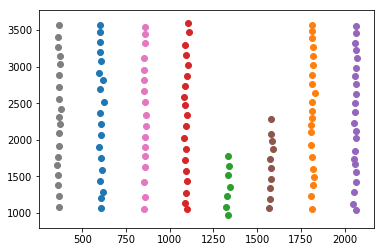

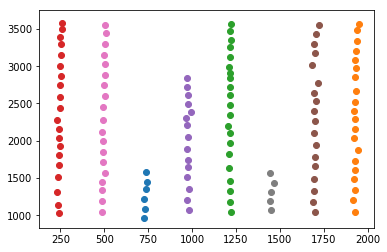

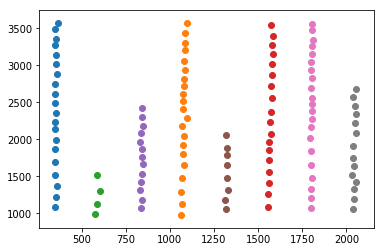

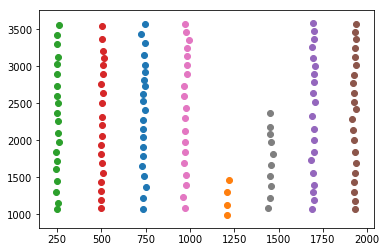

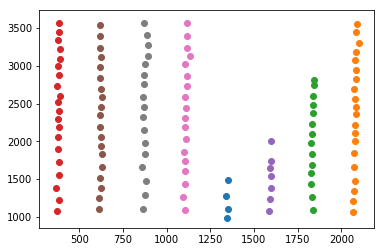

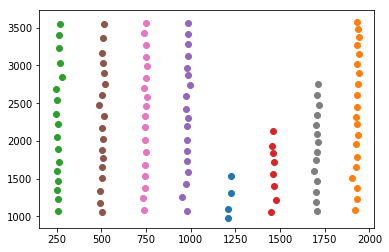

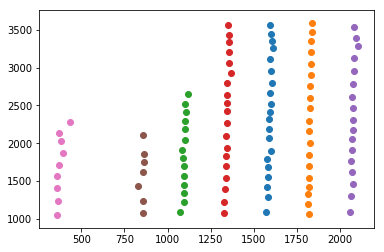

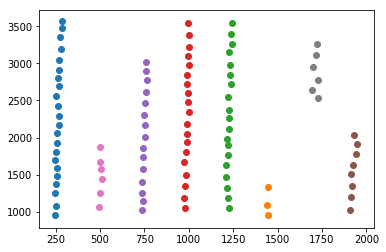

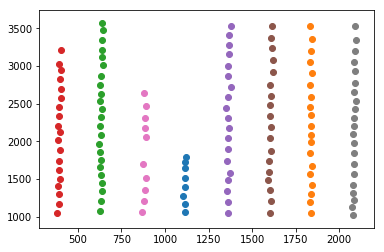

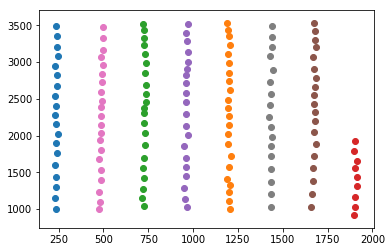

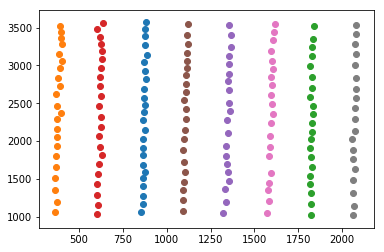

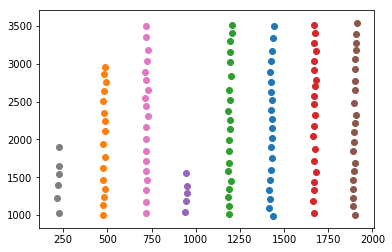

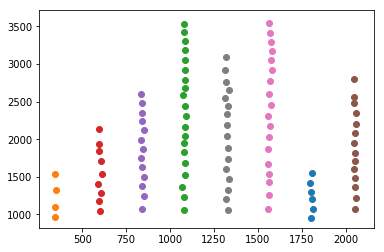

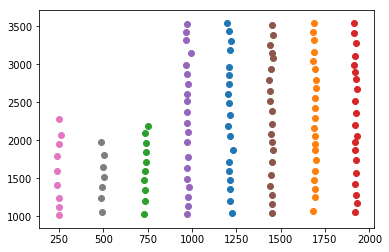

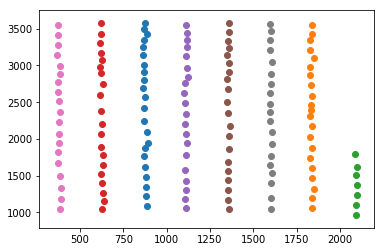

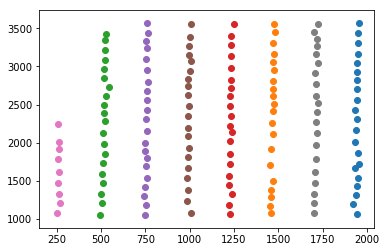

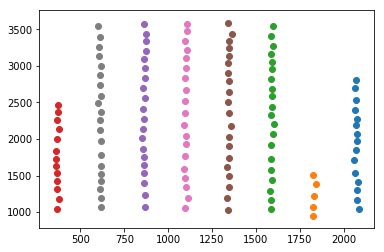

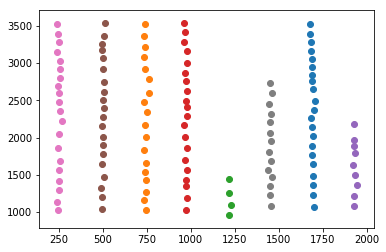

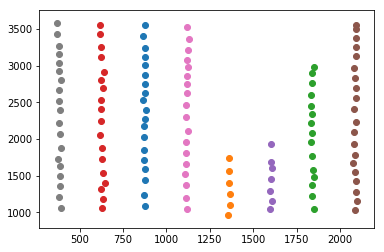

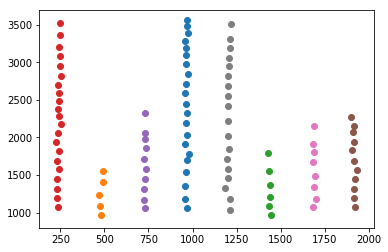

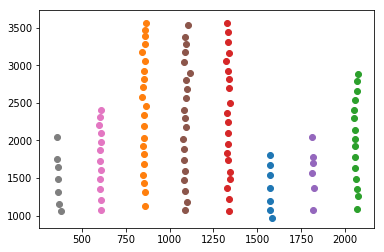

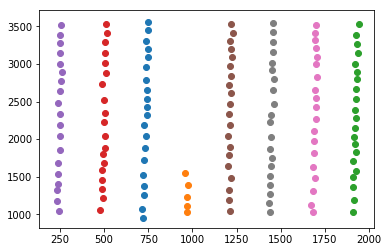

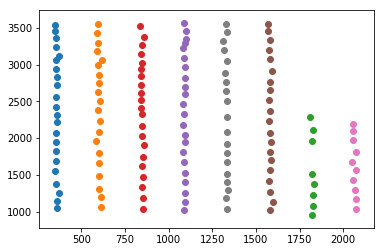

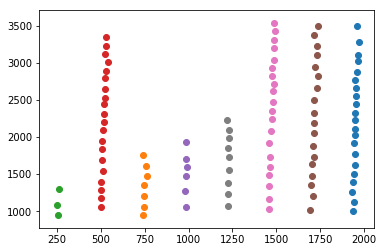

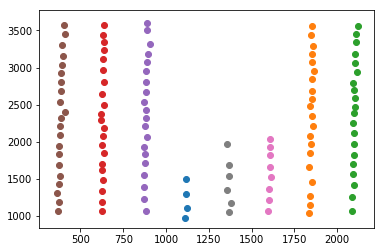

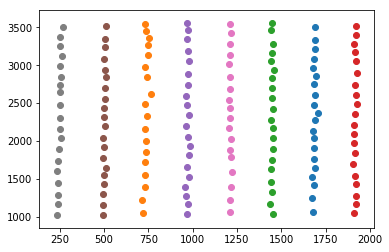

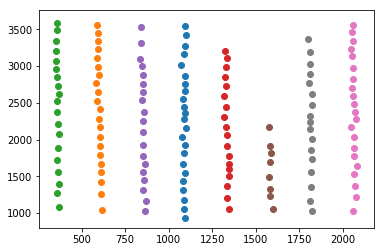

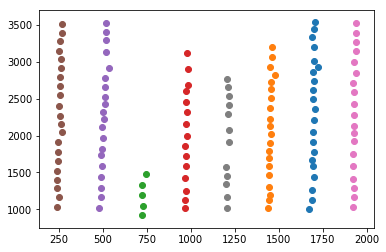

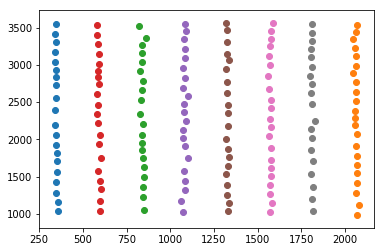

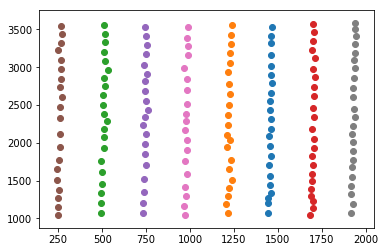

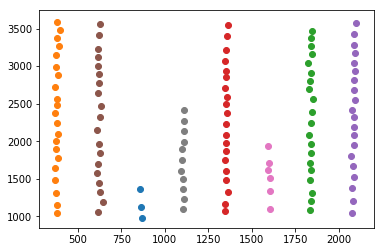

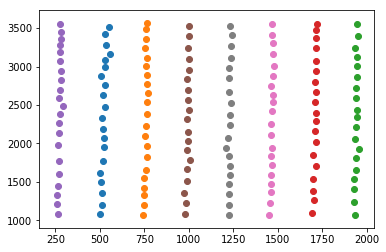

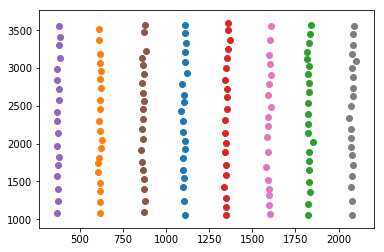

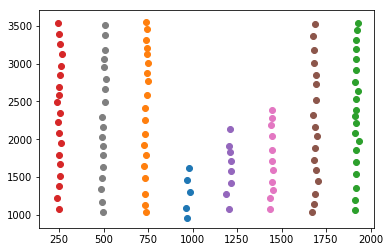

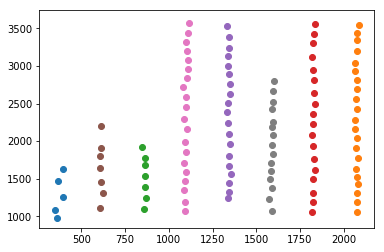

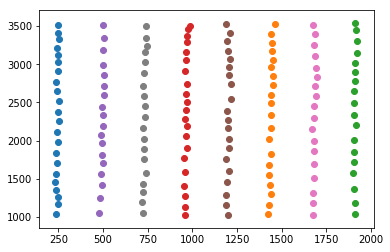

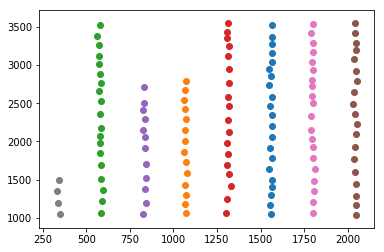

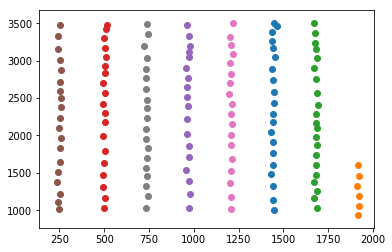

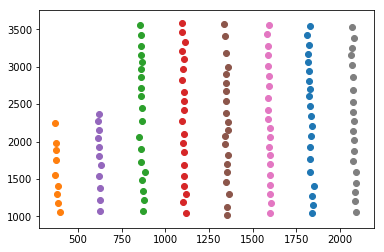

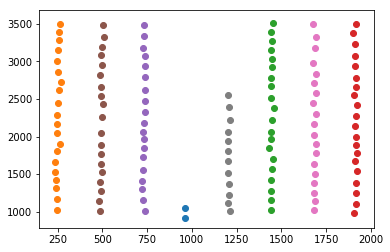

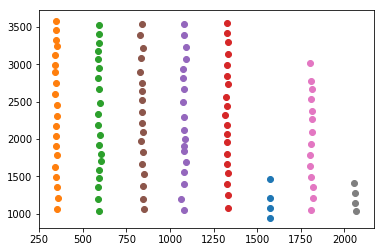

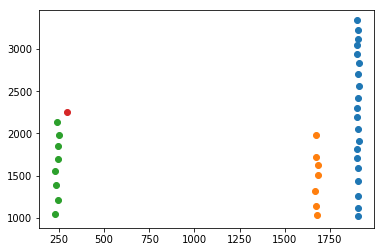

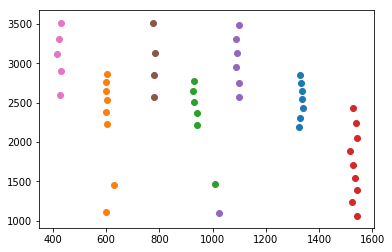

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [14]:
for idx in idx_train[:100]:
    coord = df_code.query('image_id == "{}"'.format(idx))[['x', 'y','w','h']].values
    coord_center = np.vstack([coord[:, 0] + coord[:, 2] //2, coord[:, 1] + coord[:, 3] //2]).T
    nx = find_n(coord_center, min_n=3, max_n=10)
    draw_kmean(coord_center, nx)

In [ ]:
# def find_n2(coord_center, min_n=2, max_n=10):
#     means_list = []
#     stds_list = []
#     for n in range(min_n, max_n):
#         km = KMeans(n_clusters=n)
#         X = coord_center.copy()
#         X[:, 1] = X[:, 1]/100
#         km_cluster = km.fit(X)

#         df_center = pd.DataFrame(coord_center)
#         df_center['col_n'] = km_cluster.labels_

#         cols = df_center['col_n'].unique()
#         for col in cols:
#             temp = df_center.query('col_n == {}'.format(col))
#         means_list.append(df_center.groupby('col_n').mean().std().values)
#         stds_list.append(df_center.groupby('col_n').std().mean().values)

#     means = np.array(means_list)
#     yms = np.log(means[:, 1])
#     n_yms = np.argmax(yms[1:] - yms[:-1])

#     stds = np.array(stds_list)
#     xsm = np.log(stds[:,0])
#     n_xsm = np.argmin(xsm[1:] - xsm[:-1]) + 1
    
#     return n_yms+min_n, n_xsm+min_n

In [ ]:
# means_list = []
# stds_list = []
# for n in range(2, 10):
#     km = KMeans(n_clusters=n)
#     X = coord_center.copy()
#     X[:, 1] = X[:, 1]/100
#     km_cluster = km.fit(X)

#     df_center = pd.DataFrame(coord_center)
#     df_center['col_n'] = km_cluster.labels_

#     cols = df_center['col_n'].unique()
#     for col in cols:
#         temp = df_center.query('col_n == {}'.format(col))
# #         plt.scatter(temp[0], temp[1])
#     means_list.append(df_center.groupby('col_n').mean().std().values)
#     stds_list.append(df_center.groupby('col_n').std().mean().values)
# #     plt.show()
    
# means = np.array(means_list)
# yms = np.log(means[:, 1])
# n_yms = ymsnp.argmax(yms[1:] - yms[:-1])

# stds = np.array(stds_list)
# xsm = np.log(stds[:,0])
# n_xsm = np.argmin(xsm[1:] - xsm[:-1]) + 1

In [ ]:
# def draw_kmean2(coord_center, n, m):
#     plt.subplot(211)
#     km = KMeans(n_clusters=n)
#     X = coord_center.copy()
#     X[:, 1] = X[:, 1]/100
#     km_cluster = km.fit(X)

#     df_center = pd.DataFrame(coord_center)
#     df_center['col_n'] = km_cluster.labels_

#     cols = df_center['col_n'].unique()
#     for col in cols:
#         temp = df_center.query('col_n == {}'.format(col))
#         plt.scatter(temp[0], temp[1])
#     plt.show()   
    
#     plt.subplot(212)
#     km = KMeans(n_clusters=m)
#     X = coord_center.copy()
#     X[:, 1] = X[:, 1]/100
#     km_cluster = km.fit(X)

#     df_center = pd.DataFrame(coord_center)
#     df_center['col_n'] = km_cluster.labels_

#     cols = df_center['col_n'].unique()
#     for col in cols:
#         temp = df_center.query('col_n == {}'.format(col))
#         plt.scatter(temp[0], temp[1])
#     plt.show()   

In [ ]:
# np.random.seed(1337)

# for i in range(10):
#     img, labels = df_train.values[i]
#     viz = visualize_training_data(FOLDER + '/train_images/{}.jpg'.format(img), labels)
    
#     plt.figure(figsize=(15, 15))
#     plt.title(img)
#     plt.imshow(viz, interpolation='lanczos')
#     plt.show()